# Example Run of an Augmented Simulator (Tensorflow version)
As the previous Notebook (4_How_to_contribute), you can implement your tensorflow architecture using 

- the template provided by LIPS framework; 
- a completely custom architecture with your own train and predict functions. 

However, your final solution should be evaluated through the LIPS framework to obtain the metrics and a general score. 

### Prerequisites

Install the LIPS framework if it is not already done. For more information look at the LIPS framework [Github repository](https://github.com/IRT-SystemX/LIPS) 

In [ ]:
# !pip install -r requirements.txt
# or 
# !pip install -U .
# pip install tensorflow==2.8.0
# pip install protobuf==3.20.1

Install the AirfRANS package

In [ ]:
# !pip install airfrans

### Generic Step (Load the required data) <a id='generic_step'></a>

In [ ]:
import os
from lips import get_root_path

In [4]:
# indicate required paths
LIPS_PATH = get_root_path()
DIRECTORY_NAME = 'Dataset'
BENCHMARK_NAME = "Case1"
LOG_PATH = LIPS_PATH + "lips_logs.log"

In [12]:
BENCH_CONFIG_PATH = os.path.join("airfoilConfigurations","benchmarks","confAirfoil.ini") #Configuration file related to the benchmark
SIM_CONFIG_PATH = os.path.join("airfoilConfigurations","simulators","tf_fc.ini") #Configuration file re

Loading the dataset using the dedicated class used by LIPS platform offers a list of advantages:

1. Ease the importing of datasets
1. A set of functions to organize the `inputs` and `outputs` required by augmented simulators


In [ ]:
from lips.benchmark.airfransBenchmark import AirfRANSBenchmark

benchmark=AirfRANSBenchmark(benchmark_path = DIRECTORY_NAME,
                            config_path = BENCH_CONFIG_PATH,
                            benchmark_name = BENCHMARK_NAME,
                            log_path = LOG_PATH)
benchmark.load(path=DIRECTORY_NAME)

In [9]:
print("Input attributes (features): ", benchmark.config.get_option("attr_x"))
print("Output attributes (targets): ", benchmark.config.get_option("attr_y"))

Input attributes (features):  ('x-position', 'y-position', 'x-inlet_velocity', 'y-inlet_velocity', 'distance_function', 'x-normals', 'y-normals')
Output attributes (targets):  ('x-velocity', 'y-velocity', 'pressure', 'turbulent_viscosity')


### Evaluate an existing augmented simulator

We start by importing an architecture from exisiting set of architectures and instantiate the `TfFullyConnectedAirfoil` class which offers a set of utilities to train and analyze the selected augmented simulator. User could play with the configuration file of an existing augmented simulator to modify the model hyperparameters.

The configuration file could be found at `./configurations/airfoil/simulators/tf_fc.ini`:

```output
[DEFAULT]
name = "tf_fc"
layers = (64,64,8,64,64,64,8,64,64)
activation = "relu"
layer = "linear"
input_dropout = 0.0
dropout = 0.0
metrics = ["mae"]
loss = {"name": "mse",
        "params": {"size_average": None,
                   "reduce": None,
                   "reduction": 'mean'}}
device = "cpu"
optimizer = {"name": "adam",
             "params": {"lr": 2e-4}}
train_batch_size = 128000
eval_batch_size = 256000
epochs = 5
shuffle = True
save_freq = False
ckpt_freq = 50
```

In the example below we select the configuration provided in `[DEFAULT]` section and new configuration could be created using a new section name and modifying the existing parameters.

Tensorflow users may use the commands below to select a GPU from the available physical devices.

In [ ]:
# Use a GPU
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # Visible devices must be set at program startup
        print(e)

In [ ]:
# see the list of selected devices
tf.config.experimental.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
from lips.augmented_simulators.tensorflow_models.airfoil.fully_connected import TfFullyConnectedAirfoil
from lips.dataset.scaler import StandardScaler

tf_fc = TfFullyConnectedAirfoil(name="tf_fc",
                                bench_config_path=BENCH_CONFIG_PATH,
                                bench_config_name=BENCHMARK_NAME,
                                sim_config_path=SIM_CONFIG_PATH,
                                sim_config_name="DEFAULT",
                                scaler=StandardScaler,
                                log_path=LOG_PATH)

Train the augmented simulator using the benchmark datasets.

In [ ]:
tf_fc.train(train_dataset=benchmark.train_dataset,
            epochs=200
           )

Visualize the convergence

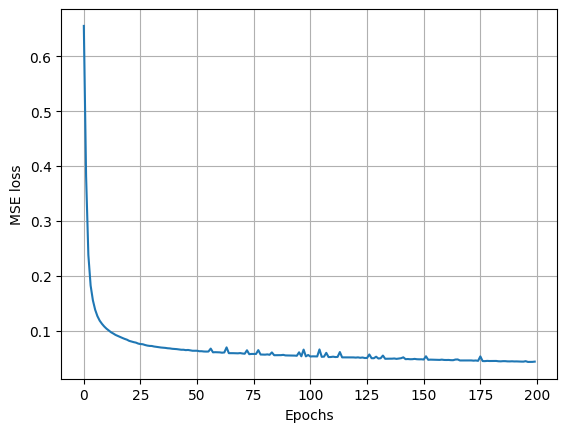

In [15]:
import matplotlib.pyplot as plt

plt.plot(tf_fc.train_losses)
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.grid()
plt.show()

In [ ]:
print("Number of parameters :", tf_fc.count_parameters())

In [ ]:
tf_fc.summary()

### Evaluation

In [16]:
# EVAL_SAVE_PATH = get_path(EVALUATION_PATH, benchmark1)
tf_fc_metrics = benchmark.evaluate_simulator(augmented_simulator=tf_fc,
                                             eval_batch_size=256000,
                                             dataset="test",
                                             shuffle=False,
                                             save_path=None,
                                             save_predictions=False
                                            )

In [ ]:
tf_fc_metrics["test"]